In [ ]:
import numpy as np
import scanpy as sc
import cell2location
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

In [ ]:
import mygene
import scanpy as sc

In [168]:
adata_vis = sc.read_visium("/root/data/LM_1")

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [169]:
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

In [171]:
adata_vis.var['SYMBOL'] = adata_vis.var_names

In [172]:
#adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

In [173]:
adata_vis.var

gene_ids    feature_types  genome       SYMBOL
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  MIR1302-2HG
FAM138A      ENSG00000237613  Gene Expression  GRCh38      FAM138A
OR4F5        ENSG00000186092  Gene Expression  GRCh38        OR4F5
AL627309.1   ENSG00000238009  Gene Expression  GRCh38   AL627309.1
AL627309.3   ENSG00000239945  Gene Expression  GRCh38   AL627309.3
...                      ...              ...     ...          ...
AC141272.1   ENSG00000277836  Gene Expression  GRCh38   AC141272.1
AC023491.2   ENSG00000278633  Gene Expression  GRCh38   AC023491.2
AC007325.1   ENSG00000276017  Gene Expression  GRCh38   AC007325.1
AC007325.4   ENSG00000278817  Gene Expression  GRCh38   AC007325.4
AC007325.2   ENSG00000277196  Gene Expression  GRCh38   AC007325.2

[36601 rows x 4 columns]

In [174]:
adata_ref = sc.read("./data/LM_scRNA_for_C2L.h5ad")

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [175]:
adata_ref.var['SYMBOL'] = adata_ref.var.index

In [176]:
adata_ref.var.index

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [ ]:
# rename 'GeneID-2' as necessary for your data
#adata_ref.var.set_index('GeneID-2', drop=True, inplace=True)

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
#del adata_ref.raw

In [177]:
adata_ref.var.set_index

<bound method DataFrame.set_index of                 features       SYMBOL
MIR1302-2HG  MIR1302-2HG  MIR1302-2HG
FAM138A          FAM138A      FAM138A
OR4F5              OR4F5        OR4F5
AL627309.1    AL627309.1   AL627309.1
AL627309.3    AL627309.3   AL627309.3
...                  ...          ...
AC141272.1    AC141272.1   AC141272.1
AC023491.2    AC023491.2   AC023491.2
AC007325.1    AC007325.1   AC007325.1
AC007325.4    AC007325.4   AC007325.4
AC007325.2    AC007325.2   AC007325.2

[36601 rows x 2 columns]>

In [178]:
adata_ref.var

features       SYMBOL
MIR1302-2HG  MIR1302-2HG  MIR1302-2HG
FAM138A          FAM138A      FAM138A
OR4F5              OR4F5        OR4F5
AL627309.1    AL627309.1   AL627309.1
AL627309.3    AL627309.3   AL627309.3
...                  ...          ...
AC141272.1    AC141272.1   AC141272.1
AC023491.2    AC023491.2   AC023491.2
AC007325.1    AC007325.1   AC007325.1
AC007325.4    AC007325.4   AC007325.4
AC007325.2    AC007325.2   AC007325.2

[36601 rows x 2 columns]

In [179]:
results_folder = './results/LM/'
# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [180]:
adata_vis.var

gene_ids    feature_types  genome       SYMBOL
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  MIR1302-2HG
FAM138A      ENSG00000237613  Gene Expression  GRCh38      FAM138A
OR4F5        ENSG00000186092  Gene Expression  GRCh38        OR4F5
AL627309.1   ENSG00000238009  Gene Expression  GRCh38   AL627309.1
AL627309.3   ENSG00000239945  Gene Expression  GRCh38   AL627309.3
...                      ...              ...     ...          ...
AC141272.1   ENSG00000277836  Gene Expression  GRCh38   AC141272.1
AC023491.2   ENSG00000278633  Gene Expression  GRCh38   AC023491.2
AC007325.1   ENSG00000276017  Gene Expression  GRCh38   AC007325.1
AC007325.4   ENSG00000278817  Gene Expression  GRCh38   AC007325.4
AC007325.2   ENSG00000277196  Gene Expression  GRCh38   AC007325.2

[36601 rows x 4 columns]

In [181]:
#去除空间转录组数据中线粒体基因的影响
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
adata_vis.obsm['MT'] = adata_vis[:,adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [182]:
adata_ref.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


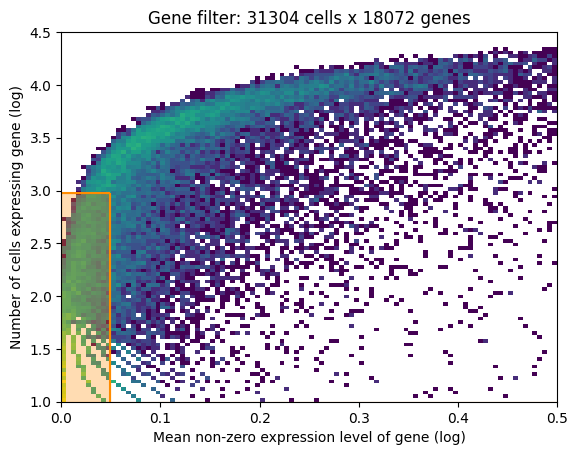

In [183]:
#过滤低表达基因
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
adata_ref = adata_ref[:, selected].copy()

In [184]:
adata_ref.obs

orig.ident  nCount_RNA  nFeature_RNA  percent.mt  \
chang1_AAACCCAAGACAGTCG.1     chang1      2382.0          1319    4.408060   
chang1_AAACCCAAGAGCCGTA.1     chang1      6150.0          2237   10.048780   
chang1_AAACCCAAGCGTATGG.1     chang1     20604.0          5224    3.581829   
chang1_AAACCCAAGGCATCAG.1     chang1      6761.0          2857    2.233397   
chang1_AAACCCAAGGGTCACA.1     chang1     24065.0          5540    5.206732   
...                              ...         ...           ...         ...   
gan2_TTTGGTTTCCTGTAAG.1         gan2      2932.0          1356    7.366985   
gan2_TTTGTTGAGAAGCCTG.1         gan2      2679.0          1379    4.927212   
gan2_TTTGTTGCACCGTGAC.1         gan2      1408.0           964    4.900568   
gan2_TTTGTTGCACTTGACA.1         gan2      4660.0          1859    5.944206   
gan2_TTTGTTGCAGCTGTTA.1         gan2      3459.0          1608    4.018502   

                           percent.ribo  seurat_clusters Major_celltype  \
chang1_AAACCCAAGACAGTCG.1      9.571788                5          T/ILC   
chang1_AAACCCAAGAGCCGTA.1      9.154472                2    Fibroblasts   
chang1_AAACCCAAGCGTATGG.1     15.613473                1    Endothelial   
chang1_AAACCCAAGGCATCAG.1      5.546517                6    Endothelial   
chang1_AAACCCAAGGGTCACA.1     15.969250                8    Endothelial   
...                                 ...              ...            ...   
gan2_TTTGGTTTCCTGTAAG.1        0.511596                0          T/ILC   
gan2_TTTGTTGAGAAGCCTG.1        0.671892                9          T/ILC   
gan2_TTTGTTGCACCGTGAC.1        1.491477                6        Myeloid   
gan2_TTTGTTGCACTTGACA.1        2.231760                4          T/ILC   
gan2_TTTGTTGCAGCTGTTA.1        1.850246                4          T/ILC   

                          Mini_celltype  set Patients     immunecells  \
chang1_AAACCCAAGACAGTCG.1          CD4+  CRC     CRC1     immunecells   
chang1_AAACCCAAGAGCCGTA.1   Fibroblasts  CRC     CRC1  nonimmunecells   
chang1_AAACCCAAGCGTATGG.1   Endothelial  CRC     CRC1  nonimmunecells   
chang1_AAACCCAAGGCATCAG.1   Endothelial  CRC     CRC1  nonimmunecells   
chang1_AAACCCAAGGGTCACA.1   Endothelial  CRC     CRC1  nonimmunecells   
...                                 ...  ...      ...             ...   
gan2_TTTGGTTTCCTGTAAG.1            CD8+   LM      LM2     immunecells   
gan2_TTTGTTGAGAAGCCTG.1            CD8+   LM      LM2     immunecells   
gan2_TTTGTTGCACCGTGAC.1       Monocytes   LM      LM2     immunecells   
gan2_TTTGTTGCACTTGACA.1            CD8+   LM      LM2     immunecells   
gan2_TTTGTTGCAGCTGTTA.1            CD8+   LM      LM2     immunecells   

                          sub_celltype  sub_sub_celltype       Subset  
chang1_AAACCCAAGACAGTCG.1          CD4                 3        T/ILC  
chang1_AAACCCAAGAGCCGTA.1  Fibroblasts                45  Fibroblasts  
chang1_AAACCCAAGCGTATGG.1  Endothelial                31  Endothelial  
chang1_AAACCCAAGGCATCAG.1  Endothelial                29  Endothelial  
chang1_AAACCCAAGGGTCACA.1  Endothelial                37  Endothelial  
...                                ...               ...          ...  
gan2_TTTGGTTTCCTGTAAG.1            CD4                 0        T/ILC  
gan2_TTTGTTGAGAAGCCTG.1           MAIT                16        T/ILC  
gan2_TTTGTTGCACCGTGAC.1        Myeloid                19      Myeloid  
gan2_TTTGTTGCACTTGACA.1            CD8                10        T/ILC  
gan2_TTTGTTGCAGCTGTTA.1            CD8                10        T/ILC  

[31304 rows x 14 columns]

In [185]:
#adata_ref.obs
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                           batch_key='orig.ident',
                           labels_key='Subset'
                           #categorical_covariate_keys=['Method']
                          )

In [186]:
#cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                       # batch_key='Sample',
                        # cell type, covariate used for constructing signatures
                       # labels_key='Subset'
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        #categorical_covariate_keys=['Method']
                       #)

In [187]:
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'orig.ident',
│   'labels_key': 'Subset',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   4   │
│         n_cells          │ 31304 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   6   │
│          n_vars          │ 18072 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │   chang1   │          0          │
│                         │   chang2   │          1          │
│                         │    gan1    │          2          │
│                         │    gan2    │          3          │
└─────────────────────────┴────────────┴─────────────────────┘

                   labels State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │  B/Plasma   │          0          │
│                     │ Endothelial │          1          │
│                     │ Epithelial  │          2          │
│                     │ Fibroblasts │          3          │
│                     │   Myeloid   │          4          │
│                     │    T/ILC    │          5          │
└─────────────────────┴─────────────┴─────────────────────┘

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [13:17<00:00,  7.68s/it, v_num=1, elbo_train=2.59e+8]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [13:17<00:00,  7.97s/it, v_num=1, elbo_train=2.59e+8]


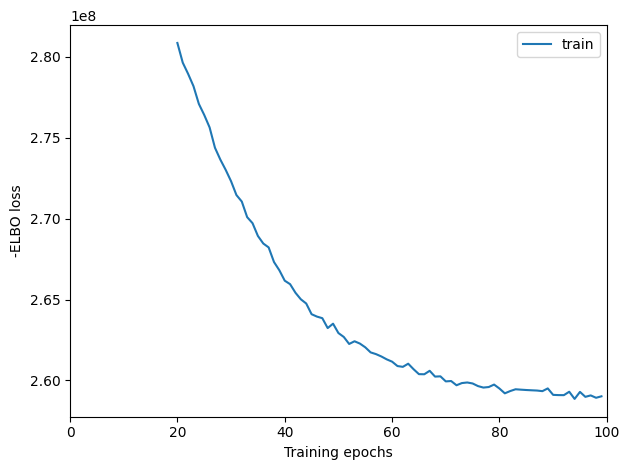

In [188]:
#训练模型，要在数据上实现收敛，需要增加max_epochs参数。如果服务器有GPU，将use_gpu设置成True将显著加快训练速度。
mod.train(max_epochs=150, use_gpu=True)
mod.plot_history(20)

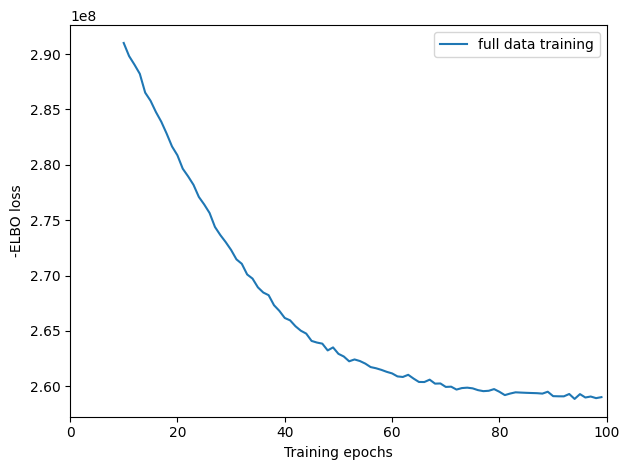

In [193]:
mod.plot_history(10)
plt.legend(labels=['full data training'])

In [194]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
#基于后验分布，计算基因在cluster中的表达
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:16<00:00, 60.04it/s]


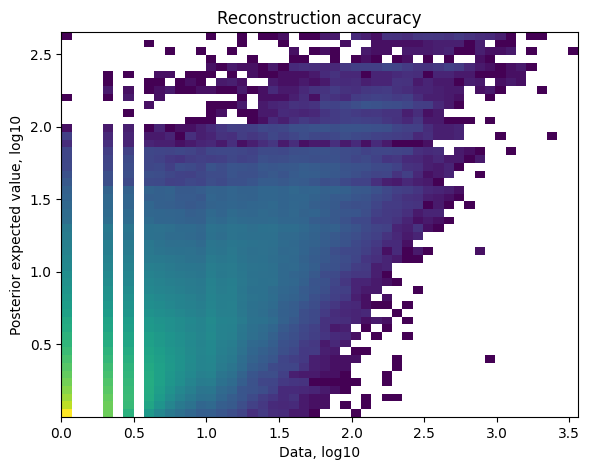

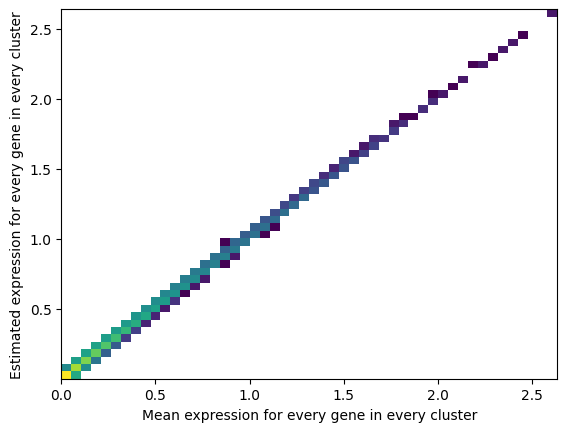

In [195]:
# Save model
mod.save(f"{ref_run_name}", overwrite=True)
mod.plot_QC()

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
#adata_ref.write(adata_file)
adata_file

In [197]:
ref_run_name

'./results/LM//reference_signatures'

In [198]:
#adata_file = f"{ref_run_name}/sc.h5ad"
#adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File ./results/LM//reference_signatures/model.pt already downloaded                                       


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/639:   0%|          | 1/639 [00:00<06:01,  1.77it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/639:   0%|          | 1/639 [00:00<06:07,  1.74it/s, v_num=1]


In [199]:
#负二项式回归模型的所有参数都导出到参考 anndata 对象中，但是对于空间映射，我们只需要每种细胞类型中每个基因的估计表达。在这里，我们从标准输出中提取：
#因为批次的问题，计算出来的特征基因的表达和平均表达并不相同
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' for i in adata_ref.uns['mod']['factor_names']]].copy()

inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

B/Plasma  Endothelial  Epithelial  Fibroblasts   Myeloid
LINC01409   0.040974     0.036192    0.235396     0.050422  0.050029
LINC01128   0.081563     0.188533    0.163004     0.166124  0.140781
SAMD11      0.000874     0.002972    0.007928     0.042668  0.001708
NOC2L       0.074536     0.310365    0.594887     0.305148  0.116667
AL645608.7  0.001123     0.044852    0.013858     0.123411  0.024964

In [200]:
#筛选交集基因
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)

In [201]:
inf_aver = inf_aver.loc[intersect, :].copy()

In [202]:
inf_aver = inf_aver[inf_aver.index.isin(intersect)].copy()

In [203]:
#print("First few var_names in adata_vis:", adata_vis.var_names[:5])
# 检查 intersect 中的元素是否都在 adata_vis.var_names 中
#if not all(elem in adata_vis.var_names for elem in intersect):
   # print("Not all elements in 'intersect' are in 'adata_vis.var_names'.")

In [204]:
adata_vis=  adata_vis[:, adata_vis.var_names.isin(intersect)].copy()### 鉴定一致性

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [205]:
# 找出重复基因的位置（保留第一个出现的位置，去除后续的重复）
duplicates_to_remove = adata_vis.var_names.duplicated(keep='first')
# 仅保留非重复的基因
adata_vis = adata_vis[:, ~duplicates_to_remove].copy()
# 检查是否还存在重复
print(adata_vis.var_names.duplicated().any())

False


In [206]:
adata_vis= adata_vis[:,intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [207]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key='sample')

In [208]:
#N_cells_per_location：每个点包含的细胞数量
#detection_alpha：如果切片间或者批次间RNA检测存在大的变异性，detection_alpha设置为20，反之可以设置为200。
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 3373  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 18057 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    gan1    │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [209]:
mod.train(max_epochs=3000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:281: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 3000/3000: 100%|██████████| 3000/3000 [08:59<00:00,  5.74it/s, v_num=1, elbo_train=1.5e+7] 

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 3000/3000: 100%|██████████| 3000/3000 [08:59<00:00,  5.56it/s, v_num=1, elbo_train=1.5e+7]


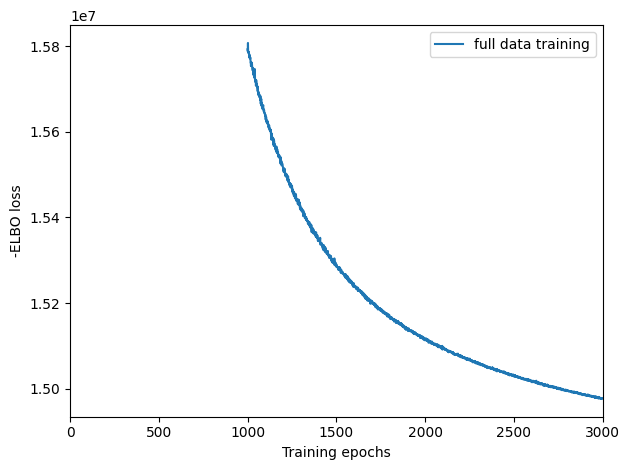

In [210]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [213]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

Sampling global variables, sample: 100%|██████████| 999/999 [00:33<00:00, 29.57it/s]


In [214]:
# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'./results/LM//cell2location_map/sp.h5ad'

In [215]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

INFO     File ./results/LM//cell2location_map/model.pt already downloaded                                          


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:281: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1/30000:   0%|          | 1/30000 [00:00<1:32:30,  5.40it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|          | 1/30000 [00:00<1:36:51,  5.16it/s, v_num=1]


In [ ]:
#当对多个空间批次进行整合时，以及当使用载玻片中检测到的RNA存在很大差异的数据集时（这不能用组织学中的高细胞密度来解释），
#重要的是要评估cell2location是否使这些效应归一化。您期望在不同批次之间看到相似的总细胞丰度，但不同的 RNA 检测灵敏度（均由 cell2location 估计）。您期望总细胞丰度反映组织学中的高细胞密度。

In [227]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

In [232]:
adata_vis.obsm['q05_cell_abundance_w_sf']

q05cell_abundance_w_sf_B/Plasma  \
AAACAAGTATCTCCCA-1                         3.217478   
AAACAATCTACTAGCA-1                         3.285272   
AAACAGGGTCTATATT-1                         1.293764   
AAACAGTGTTCCTGGG-1                         1.140825   
AAACATGGTGAGAGGA-1                         1.911522   
...                                             ...   
TTGTTTCACATCCAGG-1                         1.358205   
TTGTTTCATTAGTCTA-1                         1.384957   
TTGTTTCCATACAACT-1                         1.823669   
TTGTTTGTATTACACG-1                         0.996296   
TTGTTTGTGTAAATTC-1                         1.031765   

                    q05cell_abundance_w_sf_Endothelial  \
AAACAAGTATCTCCCA-1                            6.939729   
AAACAATCTACTAGCA-1                            1.099307   
AAACAGGGTCTATATT-1                            1.711298   
AAACAGTGTTCCTGGG-1                            0.902441   
AAACATGGTGAGAGGA-1                            4.568254   
...                                                ...   
TTGTTTCACATCCAGG-1                            1.407403   
TTGTTTCATTAGTCTA-1                            2.388074   
TTGTTTCCATACAACT-1                            4.569904   
TTGTTTGTATTACACG-1                            0.922212   
TTGTTTGTGTAAATTC-1                            1.437975   

                    q05cell_abundance_w_sf_Epithelial  \
AAACAAGTATCTCCCA-1                          16.335297   
AAACAATCTACTAGCA-1                           1.182377   
AAACAGGGTCTATATT-1                           7.744493   
AAACAGTGTTCCTGGG-1                           1.921989   
AAACATGGTGAGAGGA-1                          12.266961   
...                                               ...   
TTGTTTCACATCCAGG-1                           1.892632   
TTGTTTCATTAGTCTA-1                           0.934033   
TTGTTTCCATACAACT-1                          12.997653   
TTGTTTGTATTACACG-1                           1.341230   
TTGTTTGTGTAAATTC-1                           1.092145   

                    q05cell_abundance_w_sf_Fibroblasts  \
AAACAAGTATCTCCCA-1                            5.533251   
AAACAATCTACTAGCA-1                            1.948378   
AAACAGGGTCTATATT-1                            1.387966   
AAACAGTGTTCCTGGG-1                            3.622701   
AAACATGGTGAGAGGA-1                            3.738047   
...                                                ...   
TTGTTTCACATCCAGG-1                            3.381541   
TTGTTTCATTAGTCTA-1                            4.589508   
TTGTTTCCATACAACT-1                            3.279016   
TTGTTTGTATTACACG-1                            3.100216   
TTGTTTGTGTAAATTC-1                            1.529005   

                    q05cell_abundance_w_sf_Myeloid  \
AAACAAGTATCTCCCA-1                        2.979862   
AAACAATCTACTAGCA-1                        1.943251   
AAACAGGGTCTATATT-1                        1.955345   
AAACAGTGTTCCTGGG-1                        2.284457   
AAACATGGTGAGAGGA-1                        2.465273   
...                                            ...   
TTGTTTCACATCCAGG-1                        4.028553   
TTGTTTCATTAGTCTA-1                        2.102675   
TTGTTTCCATACAACT-1                        1.337782   
TTGTTTGTATTACACG-1                        2.399667   
TTGTTTGTGTAAATTC-1                        1.040133   

                    q05cell_abundance_w_sf_T/ILC  
AAACAAGTATCTCCCA-1                      2.658448  
AAACAATCTACTAGCA-1                      1.157098  
AAACAGGGTCTATATT-1                      1.208338  
AAACAGTGTTCCTGGG-1                      0.993927  
AAACATGGTGAGAGGA-1                      1.336478  
...                                          ...  
TTGTTTCACATCCAGG-1                      1.324427  
TTGTTTCATTAGTCTA-1                      1.361071  
TTGTTTCCATACAACT-1                      1.350102  
TTGTTTGTATTACACG-1                      1.048448  
TTGTTTGTGTAAATTC-1                      0.945820  

[3373 rows x 6 col

In [299]:
adata_vis.obs.to_csv('LM1_file.csv')

In [ ]:
#print(adata_vis.obs['batch_key'].unique())
print(adata_vis.uns["spatial"].keys())

In [ ]:
# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'gan1')

In [ ]:
print(slide.obsm["spatial"][:5])  # 假设坐标数据存储在 obsm["spatial"]

In [246]:
slide.obsm['spatial'] = np.array(slide.obsm['spatial'], dtype=float)

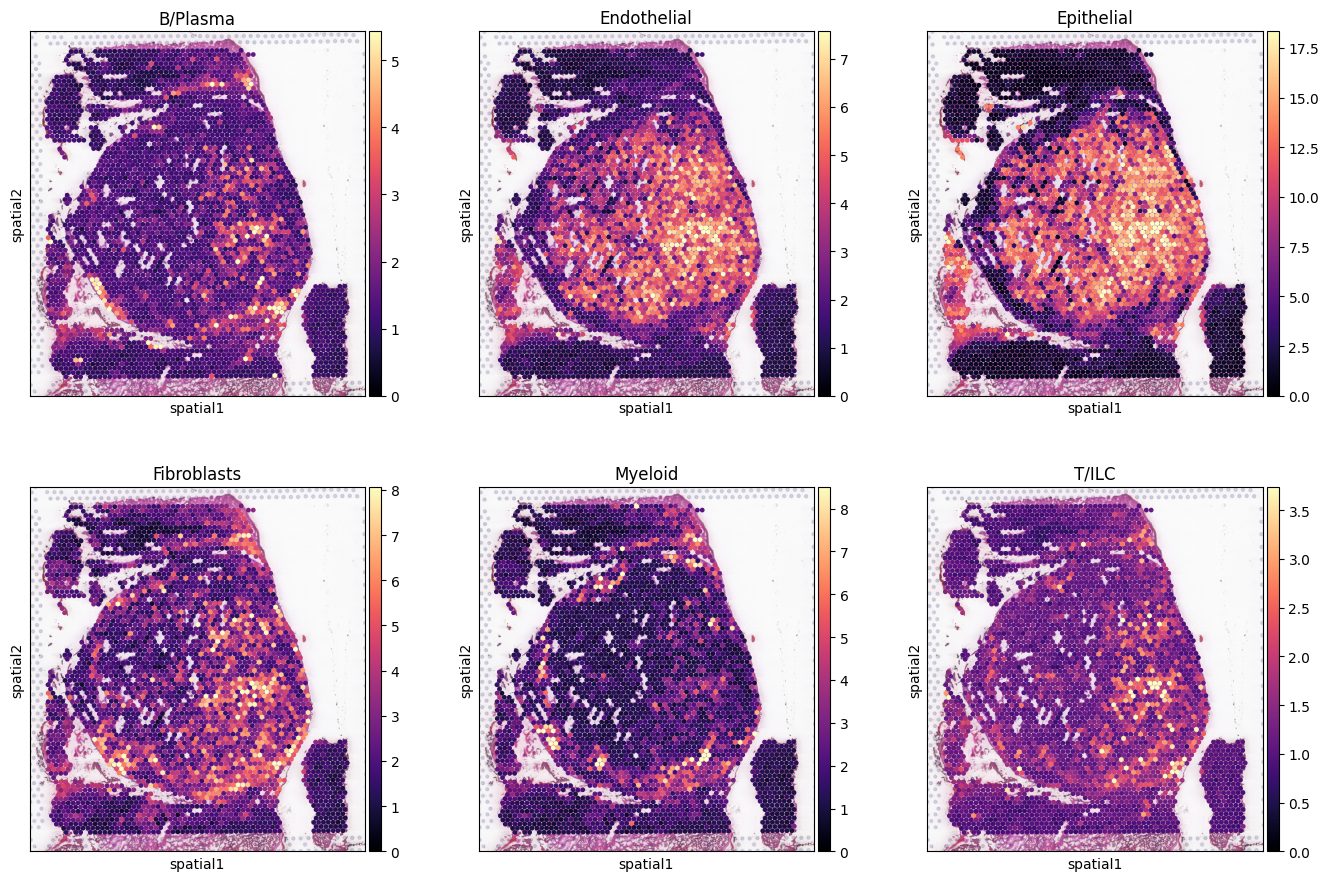

In [297]:
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor': 'black', 'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(slide, cmap='magma',
                  color=['B/Plasma', 'Endothelial', 'Epithelial', 'Fibroblasts', 'Myeloid', 'T/ILC'],
                  ncols=3, size=1.5,
                  img_key='hires',
                  vmin=0, vmax='p99.2'
                 )

In [298]:
plt.show()

In [240]:
print(slide.obsm["spatial"][:5])  # 假设坐标数据存储在 obsm["spatial"]

[['22090' '18823']
 ['11191' '3934']
 ['5799' '17980']
 ['11345' '26220']
 ['3453' '22772']]


In [292]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 4 clusters
clust_labels = ['Fibroblasts', 'Myeloid', 'T/ILC','B/Plasma']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'gan1')
slide.obsm['spatial'] = np.array(slide.obsm['spatial'], dtype=float)


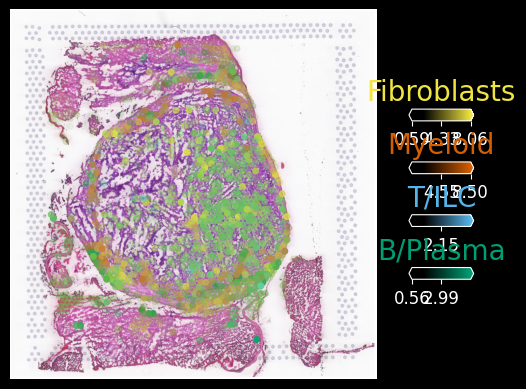

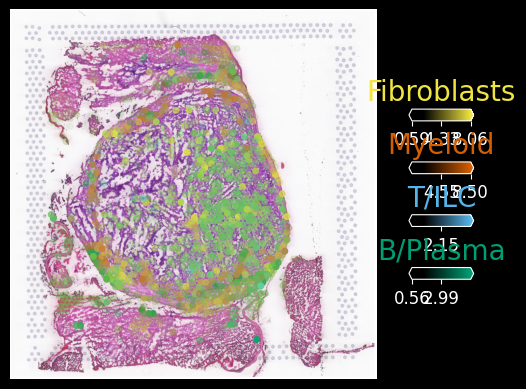

In [294]:
cell2location.plt.plot_spatial(adata=slide,
                               color=clust_col ,
                               img_key='hires', 
                               labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='dark_background',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=4,
        colorbar_position='right')

In [286]:
clust_col = {
    "Fibroblasts": "purple",  # 替换为您想要的颜色
    "Myeloid": "yellow",
    # 继续为其他群集指定颜色...
    'T/ILC':"red",
    'B/Plasma':'green'
}

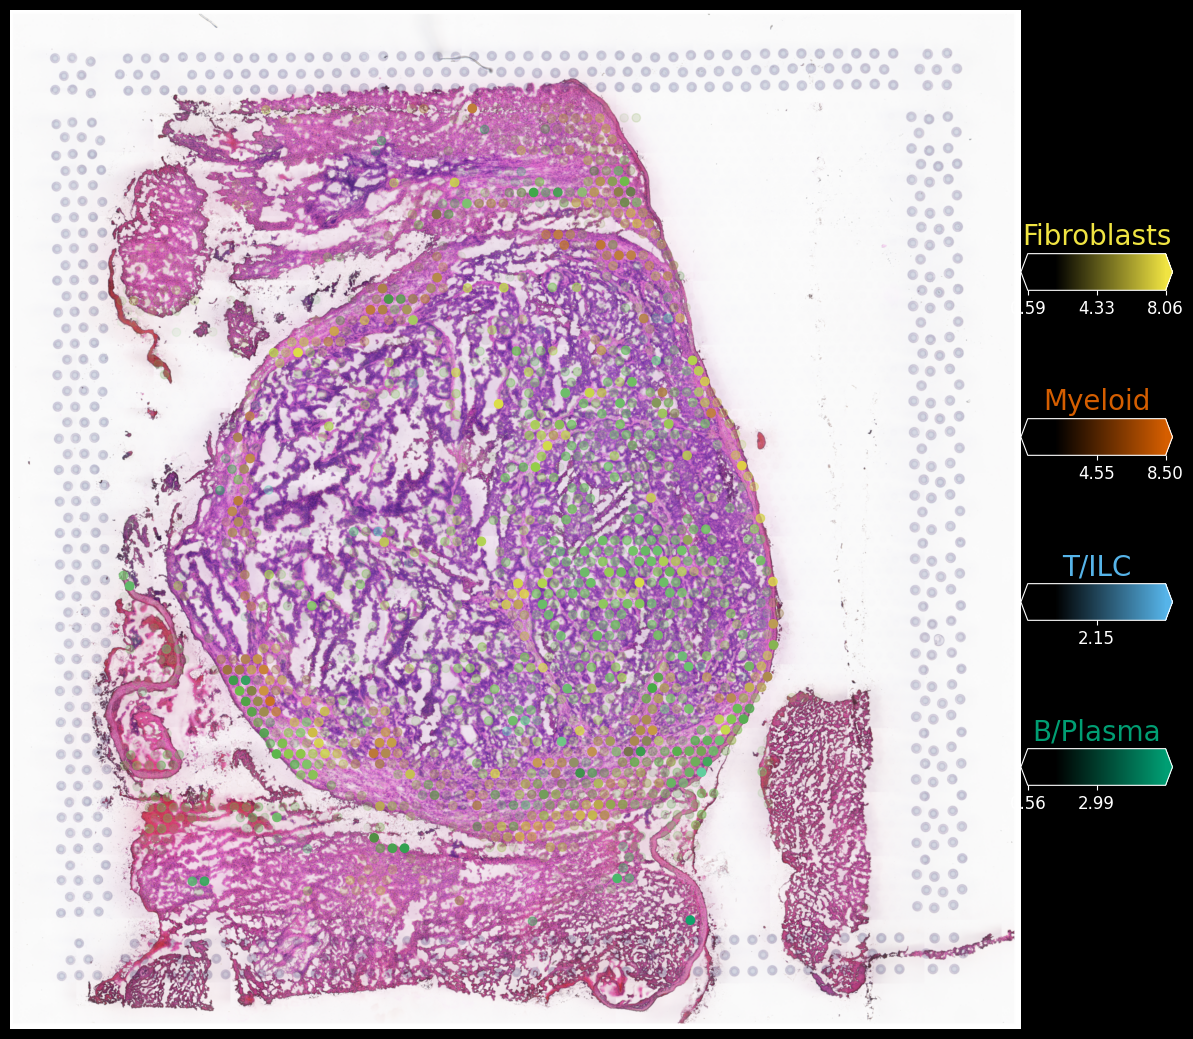

In [295]:
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col,  # 您的细胞类型列表
        #reorder_cmap=reorder_cmap,
        labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='dark_background',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )

In [ ]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

In [ ]:
# list cell types and genes for plotting
ctypes = ['B/Plasma', 'Endothelial', 'Epithelial', 'Fibroblasts', 'Myeloid', 'T/ILC']
genes = ['CD3D', 'CR2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata_vis, 'gan1')
    slide.obsm['spatial'] = np.array(slide.obsm['spatial'], dtype=float)
    from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(slide, genes, ctypes);